In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv

# Birth Death Reaction

$ \varnothing \stackrel{k_1}\longrightarrow M $

$ M \stackrel{k_2}\longrightarrow \varnothing $

BUT: reaction rate constants are not the rates of the chain, death rate is proportional to the number of molecules = $ k_2 * m $

# Simulation: Paths and Bootstrap

In [2]:
def sample_path(x0, params, tmax, plot=False):
    """
    Simulate sample path of birth death reaction

    x0 = initial state
    params = [k1, k2]
    tmax = time of simulation

    return states visited and jump times
    """

    # parameters
    k1 = params[0]
    k2 = params[1]

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate until stopping time
    while t < tmax:

        # current state
        x = path[-1]

        # rates
        q_birth = k1
        q_death = k2 * x
        q_hold = q_birth + q_death

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        if u < q_birth / q_hold:
            path.append(x + 1)
        else:
            path.append(x - 1)

    if plot:
        plt.step(jump_times, path, where="post")

    return path, jump_times

In [3]:
def bootstrap(x_list, x0, params, tmax, n, N, plot=False, printing=False):
    """
    x_list = states to calculate probabilities for
    x0 = initial state
    params = [k1, k2]
    tmax = time until sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples
    states = []
    for i in range(n):
        path, jumps = sample_path(x0, params, tmax, plot=plot)
        states.append(path[-2])
    if plot:
        plt.show()

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

### Test

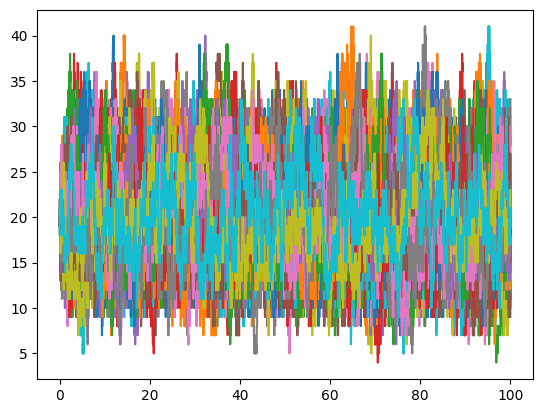

95% CI for p(19) is: (0.06, 0.18)


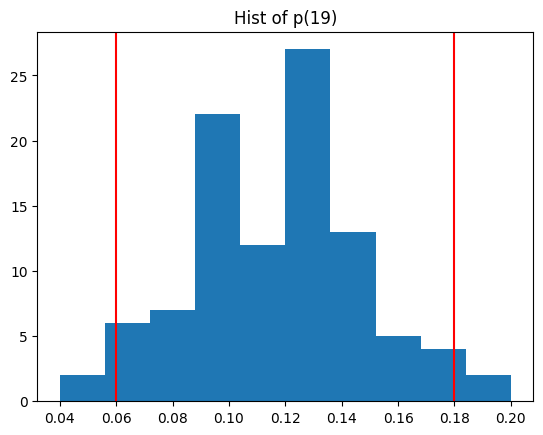

95% CI for p(20) is: (0.06475, 0.20049999999999982)


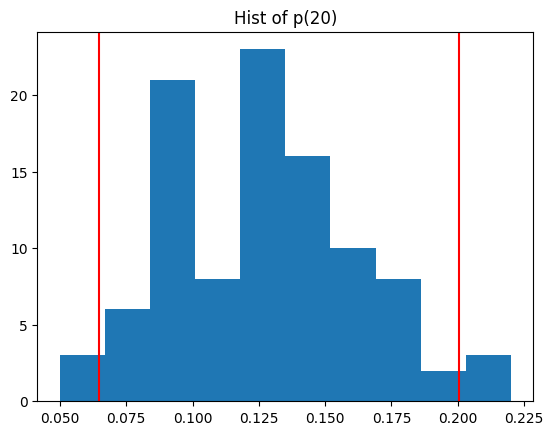

95% CI for p(21) is: (0.05, 0.14)


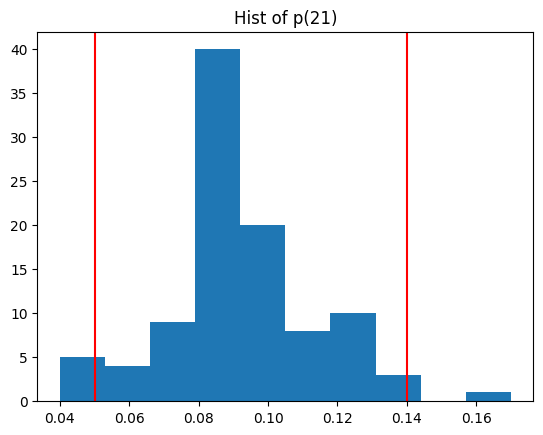

In [4]:
bootstrap([19,20,21],20,[20,1],100,100,100,plot=True,printing=True);

# Confidence intervals

## Relation to true values

Start by plotting confidence interval estimates (as intervals on a graph) against the true value p(x) they are estimating:

In [52]:
def CI_analysis_1(n, N):
    """
    Plot confidence interval estimates for a range of stationary values p(x)
    n = number of samples (from the stationary distribution)
    N = number of bootstrap samples (resamples with replacement of size n)
    """
    # fix k2
    k2 = 1
    # take selection of p(x)'s
    x_min = 0
    x_max = 5
    count = 0
    count_red = 0
    # range of k1 parameter values
    for k1 in 3 * [0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]:
    #for k1 in [1 for x in range(30)]:
        # true p(x) values
        true_p = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)]
        # bootstrap estimates
        estimates, intervals = bootstrap([x for x in range(x_min, x_max)],0,[k1,k2],100,n,N)
        # plot each CI
        for i in range(x_max - x_min):
            p = true_p[i]
            l = intervals[i][0]
            u = intervals[i][1]
            count += 1
            if l <= p and p <= u:
                color = "blue"
            else:
                color = "red"
                count_red += 1
            plt.plot([p, p], [l, u], color=color, alpha=0.7)
    plt.axline([0, 0], slope=1, color="green")
    plt.xlabel("True value of p(x)")
    plt.ylabel("CI for p(x)")
    plt.show()

    print(f"Proportion of CI's not containing true value: {count_red / count}")

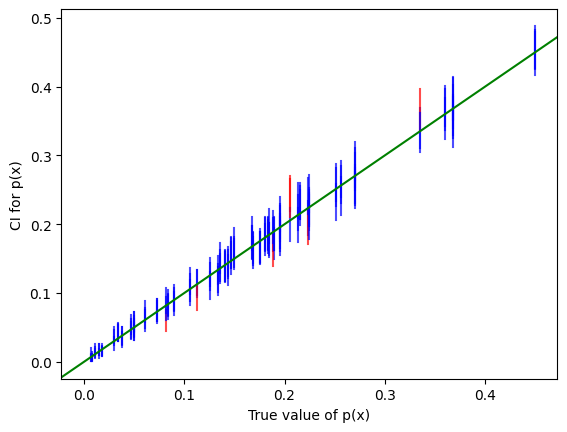

Proportion of CI's not containing true value: 0.04666666666666667


In [53]:
CI_analysis_1(1000, 1000)

### Larger sample size:

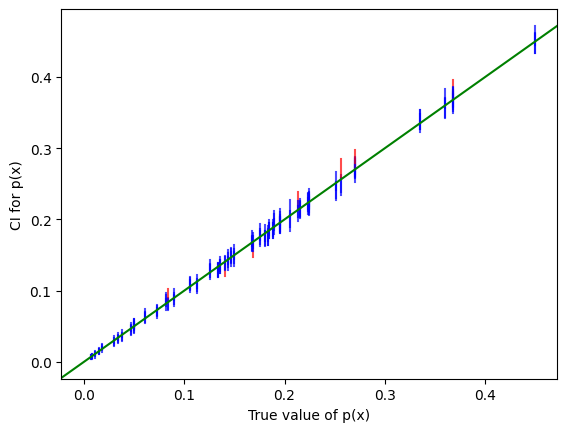

Proportion of CI's not containing true value: 0.04666666666666667


In [48]:
CI_analysis_1(5000, 5000)

### Smaller sample: increasing number of bootstrap samples

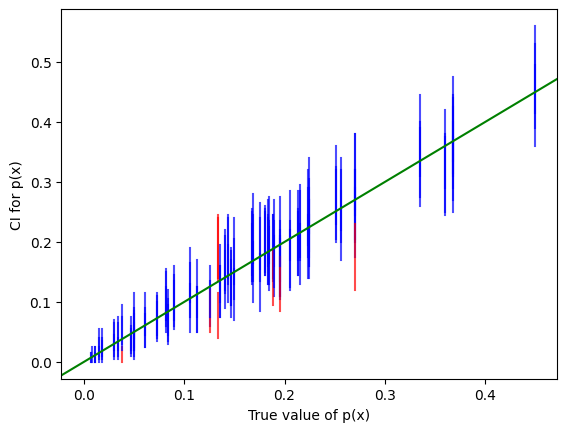

Proportion of CI's not containing true value: 0.07333333333333333


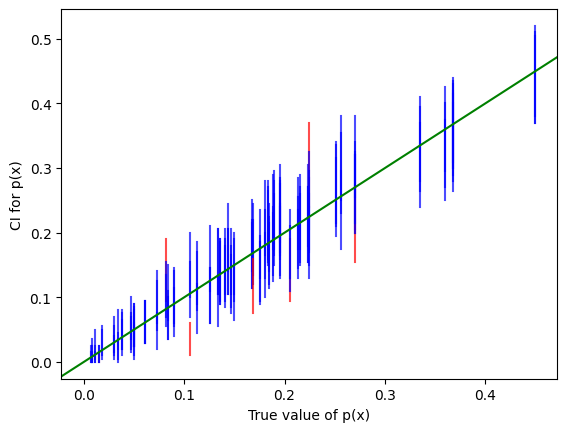

Proportion of CI's not containing true value: 0.06


In [54]:
CI_analysis_1(200, 1000)
CI_analysis_1(200, 5000)

A larger sample size visibily reduces the width of the intervals, and slightly reduces the proportion that do not contain the true value they are estimating, but this still remains at ~5% (as expected for a 95% CI).

In practice we cannot increase the size of our sample, but we see that taking more bootstrap samples slightly improves the width and accuracy of bounds on the stationary distribution, altough not significantly in the face of increased computation time, and even with 200 original samples 1000 bootstrap samples is enough to get reasonable results.

## Accuracy: containing the true value

See that the proportion of confidence interval estimates containing the true values they are estimating is ~95% (with ~5% failing to do so), which is good as taking the 2.5% and 97.5% percentiles of the bootstrap estimates we expect a 95% confidence interval.

However, if the true values to be estimated are very small probabilities this does not hold and the proportion of 'correct' CI's drops well below 95%. We would like to know more about this: what is the relationship between CI accuracy and value size

In [55]:
def CI_analysis_2(n, N):
    # fix k2
    k2 = 1
    # take selection of p(x)'s
    x_min = 0
    x_max = 10
    # range of k1 parameter values
    #for k1 in [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 5]:
    for k1 in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3,5]:
        # true p(x) values
        true_p = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)]
        
        # compute several bootstrap estimates and record accuracy
        accuracy = [0 for x in range(x_min, x_max)]
        m = 30
        for i in range(m):
            # bootstrap estimate
            estimates, intervals = bootstrap([x for x in range(x_min, x_max)],0,[k1,k2],100,n,N)
            # accuracy for each p(x)
            for x in range(x_min, x_max):
                if intervals[x][0] <= true_p[x] and true_p[x] <= intervals[x][1]:
                    accuracy[x] += 1 / m
        # plot accuracy
        plt.scatter(true_p, accuracy, color="blue")

    # plotting code
    plt.axhline(0.95, color="red")
    plt.title("Confidence Interval Accuracy ~ True Value")
    plt.xlabel("True value of p(x)")
    plt.ylabel("Accuracy of CI")
    plt.show()

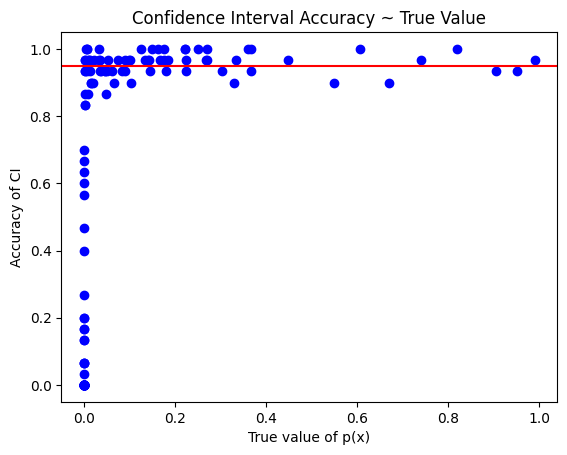

In [57]:
CI_analysis_2(1000, 1000)

Clearly see that confidence intervals for p(x) values close to 0 rarely contain the true value, but for values of p(x) that are not so small the accuracy is close to 95% or higher. 

Note: the accuracy is in general quite low because we are looking at small $k_{1}$ values (0.1 etc) and many terms of the distribution (10) which have very small values (some reaching $10^{-17}$) and so are likely to have no observations, giving an obviously innaccurate CI of [0, 0]. In practical situations we would compute CI's only for states x that have been observed (multiple times) in the sample giving much more accurate confidence intervals, matching the 95% accuracy seen earlier.

In [47]:
k1, k2 = 0.1, 1
k = 10
(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k)

2.493489357462412e-17

In conclusion, confidence intervals for p(x) values that are very close to 0 should not be trusted, as they rarely contain the true value (<< 95% of the time) and so are not suitable to use as bounds. For values of p(x) that are not very close to 0, such as in practical cases where there are at least several observations of the state x in the sample, the confidence intervals should contain the true value 95% of the time, and so are appropriate to use.

## Width: measure of confidence

The width of a confidence interval is a measure of confidence: assuming that 95% of the time the true value lies within the interval (we will assume this from now on), a smaller interval means we are more certain about the location of the true value. Since we are using the CI's as bounds on variables in a linear program there is also a direct link between the width of the CI and the width of the solution bounds, so it is important to understand how the width varies.

We compute confidence interval estimates for a range of values of p(x), plotting their widths against the true value p(x):

In [66]:
def width(intervals):
    return [interval[1] - interval[0] for interval in intervals]

In [70]:
def CI_analysis_3(t):
    # estimate 
    x_max = 10
    x_min = 0
    k2 = 1
    true_p = np.array([])
    relative_var = np.array([])
    for k1 in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5]:
        # true stat dist
        dist = np.array([(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)])
        true_p = np.append(true_p, dist)
        # find CI
        estimates, intervals = bootstrap([x for x in range(x_min, x_max)],0,[k1,k2],100,1000,1000)
        # compute widths of intervals, find relative error
        widths = np.array(width(intervals))
        if t == "abs":
            # absolute error: no change
            scaled = widths
            title = "Width of CI for p(x)"
        elif t == "rel":
            # relative error: divide width by true value
            scaled = widths / dist
            title = "Width of CI for p(x) / p(x)"
        elif t == "rel2":
            # relative error dividing width by sqrt(true value)
            scaled = widths / np.sqrt(dist)
            title = "Width of CI for p(x) / sqrt(p(x))"
        relative_var = np.append(relative_var, scaled)
    plt.scatter(true_p,relative_var)
    plt.xlabel("True value of p(x)")
    plt.ylabel(title)
    plt.show()

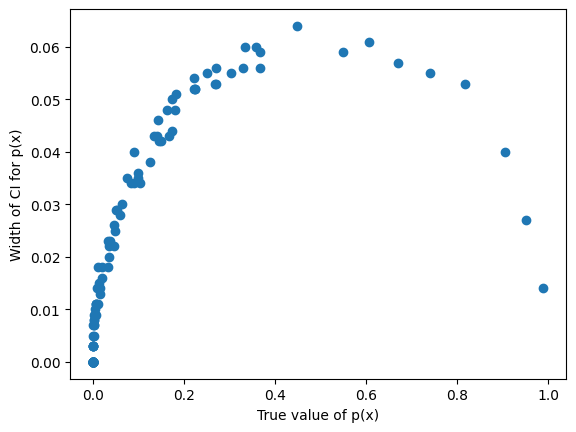

In [68]:
CI_analysis_3("abs")

We see that:

$$ \text{CI width } \propto p(x)(1 - p(x)) $$

However, the width of the CI is a measure of absolute error: p = 0.5 means we might expect 450 - 550 observations in a sample of 1000 giving an absolute error of ~0.05, for p = 0.001 even an extreme variation of 0 - 10 observations in a sample of 1000 only gives an absolute error of ~0.01 (this is just for a single point estimate, but the same idea follows for our interval estimates).

To get a measure of relative error (abolsute error relative to the size of the quantity being estimated) we can divide the width by the true value of p(x) (or $\sqrt(p(x))$):

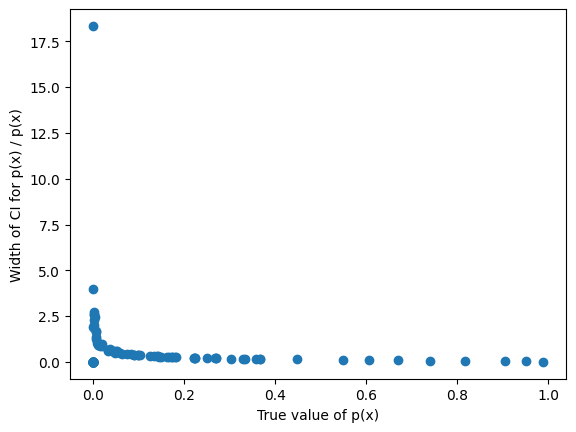

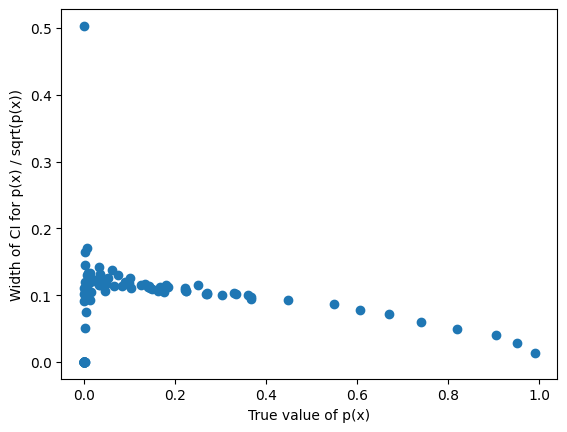

In [72]:
CI_analysis_3("rel")
CI_analysis_3("rel2")

We see that:

$$ \frac{\text{CI Width}}{p(x)} \propto \frac{1}{p(x)} $$

$$ \frac{\text{CI Width}}{\sqrt{p(x)}} \propto 1 - p(x) $$

Showing that the error decreases as p(x) increases from 0 (rapidly for case 1, more slowly for case 2) since we have sufficient observations of x in the sample to give a good estimate (lower sampling error), but that as p(x) increases towards 1 there is not a significant improvement (although the width does reduce towards 0) as we already have enough information for a good estimate.

The extreme case where p(x) is close enough to 0 that there are no observations of x in the sample can be seen: the confidence interval estimate is [0, 0] with a width of 0 (we have no estimate of uncertainty as there is no information).

# Practical concerns

In practice we do not have access to the true stationary distribution when choosing the states to use: the only information available is the sample of n observations from the stationary distribution, from which we can compute confidence interval estimates of stationary values p(x) for each x in the sample. However, including confidence intervals that are 'wrong' can lead to infeasbile or innaccurate results.

A method that seems to work well in practice is to set a 'threshold' on the number of observations of a state x in the sample needed to 'trust' the estimated confidence interval for its stationary value p(x). A value of ~3 for a sample of ~200 has been used, with confidence intervals for states below this threshold replaced by un-informative [0, 1] bounds.

We saw above that for p(x) values very close to 0 (that would give a small number of observations of x in a sample) the accuracy of confidence interval estimates was very low, the widths can vary significantly, and in the extreme case of no observations become [0, 0] (with no way to tell if this is accurate). From this it seems reasonable to consider thresholding, as # observations of x > threshold suggests that p(x) is large enough to avoid accuracy problems, especialy when working with real data where the sampling error is likely to be large.

However, we test this method on simulated data to be sure:
- simulate a sample
- compute confidence intervals for all states, marking those that fall below the threshold number of samples (and so would not be used)
- compare the properties: accuracy and width, of confidence intervals of each group (are marked states truly un-trustworthy)
- finally consider different thresholds to see if there is an 'optimal' range (is ~3 really the best?)

In [169]:
def CI_analysis_4(x0, params, tmax, n, N, threshold):
    """
    x0 = initial state
    params = [k1, k2]
    tmax = time until sample
    n = number of simulated samples
    N = number of bootstrap samples
    threshold = minimum frequency
    """

    k1, k2 = params

    # simulate sample of size n from stationary distribution
    states = []
    for i in range(n):
        path, jumps = sample_path(x0, params, tmax)
        states.append(path[-2])
    
    # take the largest state in the sample (+ 1)
    x_max = np.max(np.array(states)) + 1
    x_min = np.min(np.array(states))

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in range(x_min, x_max)]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(range(x_min, x_max)):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]

    # true stationary distribution
    true_p = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)]
    
    # plot:
    # histogram of stationary sample
    plt.hist(sample, bins=np.arange(x_min, x_max) - 0.5, density=True, label="Stationary sample");
    # threshold line
    plt.axhline(threshold / n, 0, 1, color="orange", label=f"Frequency threshold: {100 * threshold / n} %")
    # plot true stationary distribution
    plt.plot([x for x in range(x_min, x_max)], true_p, color="green", label="Stationary distribution")
    # plot confidence intervals: coloured by accuracy
    for i, interval in enumerate(intervals):
        if interval[0] <= true_p[i] and true_p[i] <= interval[1]:
            color = "blue"
        else:
            color = "red"
        x = range(x_min, x_max)[i]
        plt.plot([x, x], [interval[0], interval[1]], color=color)
    plt.title("Frequency thresholds: accuracy and width of confidence intervals")
    plt.legend()
    plt.show()

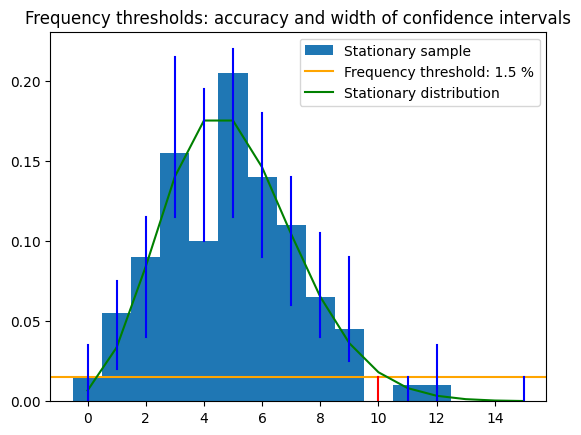

In [198]:
CI_analysis_4(1, [5, 1], 100, 200, 1000, 3)

A plot showing a histogram of the stationary sample (blue), the true stationary distribution (green), the confidence intervals for each state (vertical lines: blue if containing the true value being estimated, red if not) and a threshold frequency.

In [206]:
def CI_analysis_5(k1_list, tmax, n, N):

    # store CI data
    data = []

    # fix k2
    k2 = 1
    # range of k1 parameter values
    for k1 in k1_list:

        # setup
        x0 = 1
        params = [k1, k2]

        # simulate sample of size n from stationary distribution
        states = []
        for i in range(n):
            path, jumps = sample_path(x0, params, tmax)
            states.append(path[-2])
        
        # take the largest and smallest states in the sample (+ 1)
        x_max = np.max(np.array(states)) + 1
        x_min = np.min(np.array(states))

        # simulate N bootstrap samples: estimates p(x) for each, and for each x
        estimates = [[] for x in range(x_min, x_max)]
        for i in range(N):
            sample = random.choices(states,k = n)
            for i, x in enumerate(range(x_min, x_max)):
                estimates[i].append(sample.count(x) / n)

        # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
        intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]

        # true stationary distribution
        true_p = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)]

        # record: frequency of samples CI is based on, accuracy (T/F), width
        for i, interval in enumerate(intervals):
            # interval estimate of p(x) for state x
            x = range(x_min, x_max)[i]
            # number of occurances in the sample
            freq = sample.count(x)
            # accuracy
            if interval[0] <= true_p[i] and true_p[i] <= interval[1]:
                acc = 1
            else:
                acc = 0
            # width
            width = interval[1] - interval[0]

            # store
            data.append([freq, acc, width])

    # plot % accuracy of CI's against frequency of samples they are based on
    freqs = {x[0]: [] for x in data}
    for x in data:
        freqs[x[0]].append(x[1])
    for x, y in freqs.items():
        freqs[x] = sum(y) / len(y)
    plt.scatter(freqs.keys(), freqs.values())
    plt.xlabel("Frequency of x in stationary sample")
    plt.ylabel("Confidence intervals for p(x) containing true value (%)")
    plt.title("Accuracy of confidence intervals ~ frequency of data")
    plt.show()

    return data

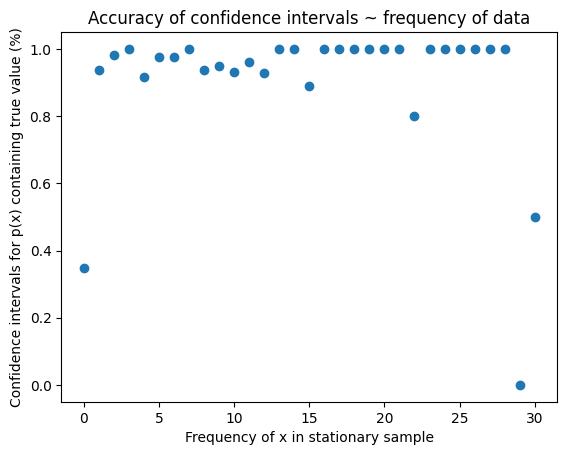

In [208]:
CI_analysis_5(10 * [20, 50], 100, 200, 1000);

There is not a clear relationship between the frequency of a state x in the sample, and the accuracy of confidence intervals estimating p(x) (i.e. not a clear relationship such as an elbow) especially since in the vast majority of cases the CI's should be accuracte 95% of the time.

However, for frequencies of states at or close to 0, the accuracy of confidence intervals is lower than 95%, even significantly so. When working with real data this effect is likely to be exacebated by greater sampling error, missing values, etc which all contribute to reduced accuracy. 

In conclusion, using thresholds on the frequency of states in the sample can avoid low accuracy confidence intervals, and we have observed good results in practice (see bursty_data_analysis for practical data exploration).

# Create LP

In [209]:
def birth_death_LP(indices, pl, pu, printing=False):
    """
    indices = list of indices of equations/rows of Q to use for constraints
    NOTE: index equations from zero
    pl = array of lower bounds on p (enough for equations used)
    pu = array of upper bounds on p ( == )

    returns:
    lower bound on k1
    upper bound on k1
    """

    # number of equations used (rows of Q) = largest equation index (+1)
    N = max(indices) + 1

    # NOTE: define one extra row and cut off, since square matrix would leave out
    # upper diagonal elements on Nth row

    # create Qr matrices
    Q1 = (np.diag([-1 for x in range(0,N+1)],0) + np.diag([1 for x in range(0,N)],-1))[:-1, :]
    Q2 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]

    # set rows to zero if equations not wanted
    for i in range(N):
        if i not in indices:
            Q1[i,:] = 0
            Q2[i,:] = 0

    # NOTE: add error for when pl, pu too small for number of equations
    # equation i involves p(i + 1)
    # so max index i => need bounds on p(i + 1), need length i + 2 = N + 1 pl/pu

    # define bounds 
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # NOTE: truncate to N + 1, as tridiagonal, so Nth equation has N+1 p's

    # Construct the problem.
    k1 = cv.Variable(1)
    k2 = 1
    z1 = cv.Variable(N + 1)
    z2 = cv.Variable(N + 1)
    objective_max = cv.Maximize(k1)
    objective_min = cv.Minimize(k1)
    constraints = [Q1 @ z1 + Q2 @ z2 == 0,
                k1 >= 0,
                z1 >= k1 * pl,
                z1 <= k1 * pu,
                z2 >= k2 * pl,
                z2 <= k2 * pu]
    prob_max = cv.Problem(objective_max, constraints)
    prob_min = cv.Problem(objective_min, constraints)   

    # Print result.
    result_max = prob_max.solve()
    if printing:
        print("\nThe upper bound is", prob_max.value)
        print("A solution k1 is")
        print(k1.value)
    max_bound = k1.value
    result_min = prob_min.solve()
    if printing:
        print("\nThe lower bound is", prob_min.value)
        print("A solution k1 is")
        print(k1.value)
    min_bound = k1.value
    
    return prob_min.value, prob_max.value

## Test

In [213]:
# create confidence intervals
k1 = 5
x_max = 12
estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,1],100,2000,2000)

# create bounds on p
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]

# use as bounds for BD LP
lb, ub = birth_death_LP([0,1,2,8,9,10],pl,pu,printing=True)


The upper bound is 5.883314267168958
A solution k1 is
[5.88331427]

The lower bound is 3.5615763537977756
A solution k1 is
[3.56157635]


# Width of solution interval v equation used

Equation n (row n of Q) involves p(n-1), p(n), p(n+1). As seen, the width of bounds on p depends on their true values.

- plot width of solution bounds against the single equation used to solve the LP
- plot upper and lower bounds against equation (same information, different visual)

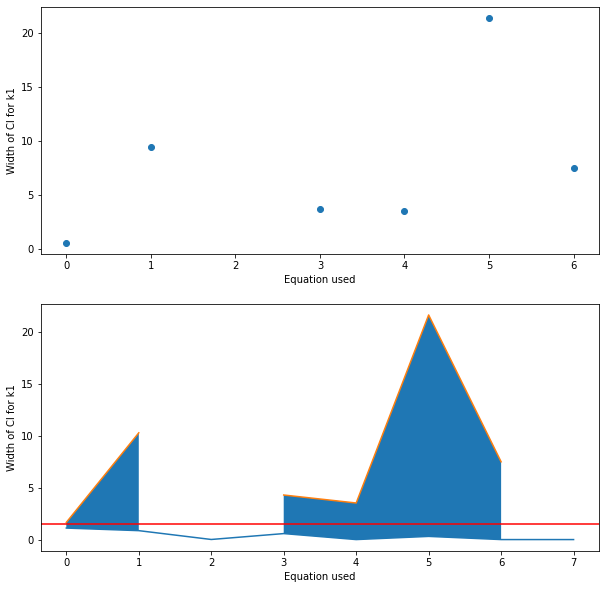

In [46]:
k1 = 1.5
solution_width = []
upper_bounds = []
lower_bounds = []
equation = []
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],0,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# using equation n: solve LP
for n in range(8):
    lb, ub = birth_death_LP([n],pl,pu)
    try:
        solution_width.append(ub - lb)
        upper_bounds.append(ub)
        lower_bounds.append(lb)
        equation.append(n)
    except TypeError:
        print(f"Type error for equation {n}, ub {ub}, lb {lb}")
# plot: scatter of width, lines of upper and lower bounds vs equation used
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))
ax[0].scatter(equation, solution_width)
ax[0].set(xlabel="Equation used", ylabel="Width of CI for k1")
ax[1].plot(equation, lower_bounds)
ax[1].plot(equation, upper_bounds)
ax[1].set(xlabel="Equation used", ylabel="Width of CI for k1")
ax[1].fill_between(equation, lower_bounds, upper_bounds)
ax[1].axhline(k1, color="red")
plt.show()

### Stationary distribution: Poisson(k1 / k2)

For integer k1 / k2 may be bi-modal, leading to solutions unbounded above when using equations involving the bi-modal states (as p(x)'s have same value, so cancel???) even though they should contain the most information.

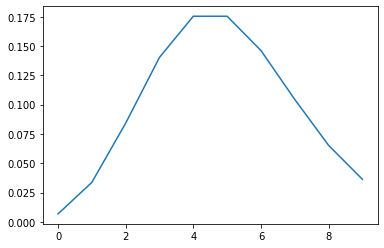

In [50]:
# distribution (to see mode)
k1 = 5
k2 = 1
dist = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(10)]
plt.plot(dist)

To find the best equation to use (for given parameters) follow the above and record the equation giving the smallest solution interval, repeat for a large number of samples and produce the distribution of best equations:

In [72]:
def equation_distribution(params, M, N):
    """
    params = [k1, k2]
    M = number of samples
    N = number of equations to use
    """
    # fixed parameters
    k1 = params[0]
    k2 = params[1]
    # store best equations
    best_equation = []
    for i in range(M):
        # store values
        solution_width = []
        upper_bounds = []
        lower_bounds = []
        equation = []
        # compute CI bounds on p(x)'s
        estimates, intervals = bootstrap([x for x in range(N + 1)],0,[k1,k2],100,1000,1000)
        pl = [intv[0] for intv in intervals]
        pu = [intv[1] for intv in intervals]
        # using equation n: solve LP
        for n in range(N):
            lb, ub = birth_death_LP([n],pl,pu)
            try:
                solution_width.append(ub - lb)
                upper_bounds.append(ub)
                lower_bounds.append(lb)
                equation.append(n)
            except TypeError:
                print(f"Type error for equation {n}, ub {ub}, lb {lb}")
        # find equation of minimum solution width
        # (NOTE: equation should be equal to index, but making sure)
        best_equation.append(equation[np.argmin(solution_width)])
    # plot distribution of best equation: proportion of equation #'s among best
    eqn_dist = [best_equation.count(x) / M for x in range(N)]
    plt.plot(eqn_dist)

    return eqn_dist

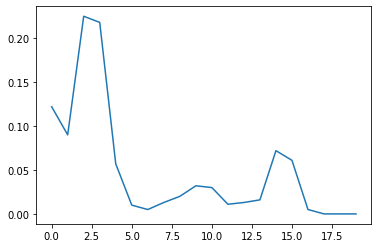

In [67]:
#

[0.47,
 0.22,
 0.07,
 0.0,
 0.0,
 0.0,
 0.01,
 0.0,
 0.0,
 0.01,
 0.02,
 0.13,
 0.07,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

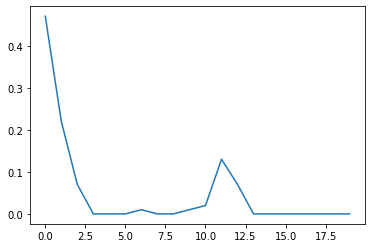

In [73]:
equation_distribution([4,1],100,20)

[0.78,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02,
 0.19,
 0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

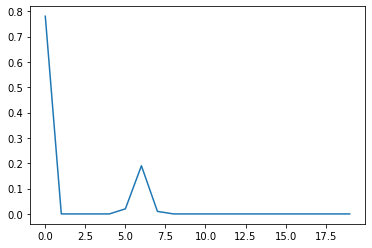

In [86]:
equation_distribution([1,1],100,20)

Change to find the equation of minimum solution width that contains the true parameter value. Add this check to see if the bumps in later states are due to small but wrong solution intevals:

In [88]:
def equation_distribution_accurate(params, M, N):
    """
    params = [k1, k2]
    M = number of samples
    N = number of equations to use
    """
    # fixed parameters
    k1 = params[0]
    k2 = params[1]
    # store best equations
    best_equation = []
    for i in range(M):
        # compute CI bounds on p(x)'s
        estimates, intervals = bootstrap([x for x in range(N + 1)],0,[k1,k2],100,1000,1000)
        pl = [intv[0] for intv in intervals]
        pu = [intv[1] for intv in intervals]
        # store best equation and width
        min_width = math.inf
        min_eqn = -1
        for n in range(N):
            # solve using equation n: find width
            lb, ub = birth_death_LP([n],pl,pu)
            width = ub - lb
            # if valid solution interval and min: update min
            if lb <= k1 and k1 <= lb and width < min_width:
                min_width = width
                min_eqn = n
        # record best equation
        best_equation.append(min_eqn)
    # plot distribution of best equation: proportion of equation #'s among best
    eqn_dist = [best_equation.count(x) / M for x in range(N)]
    plt.plot(eqn_dist)

    return eqn_dist

[0.735, 0.004, 0.0, 0.0, 0.0, 0.046, 0.212, 0.003, 0.0, 0.0, 0.0]

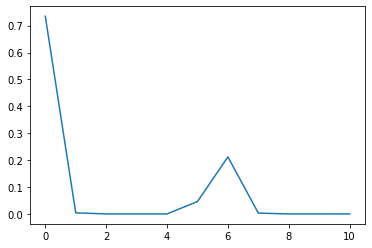

In [92]:
equation_distribution([1,1],1000,11)

See that the peak at later values is still present, so these equations do genuinely give the best solution interval a proportion of the time.

Plot the distribution of best equations for a range of parameter values: k1/k2 = 0.1, 0.25,  ..., 12, with a red line indicating k1/k2, the mode of the stationary distribution (Poi(k1/k2)):

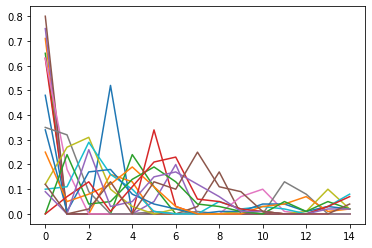

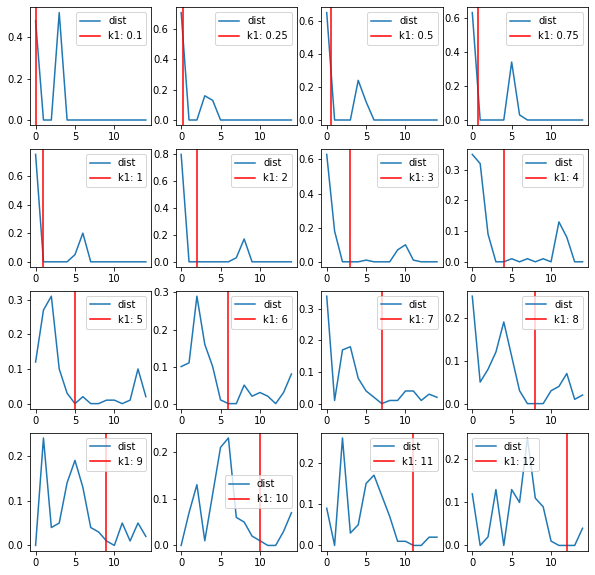

In [117]:
distributions = []
k1_list = [0.1,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10,11,12]
for k1 in k1_list:
    dist = equation_distribution([k1,1],100,15)
    distributions.append(dist)

nrows = 4
ncols = 4
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        idx = i * nrows + j
        k1 = k1_list[idx]
        ax[i,j].plot(distributions[idx])
        ax[i,j].axvline(k1, color='red')
        ax[i,j].legend(['dist',f'k1: {k1}'])
plt.show()

The red lines at k1/k2 show the mode of the stationary distribution, states at/around this value will have the largest probability values and so the smallest confidence intervals (as seen before). Equation n for this process uses states n + 1, n, n - 1, so we would expect equations around the red line to give smaller solution intevals.

However, we see that most of the time the equations around the red line are not likely to give the best solution, often never. This is suprising, but may be due to problems with bi-model values from using discrete values from the poisson stationary distribution: as shown before this leads to 2 values at the peak of the stationary distribution being equal, leading to no upper solution bound (perhaps as they cancel out in equations).

$\frac{k1}{k2} \in \mathbb{N} \implies P(X = \frac{k1}{k2}) = P(X = \frac{k1}{k2} + 1) \text{ for } X \sim Poi(\frac{k1}{k2})$ 

So states $ \frac{k1}{k2} $ and $ \frac{k1}{k2} +1 $ have the same stationary distribtuion values.

We now look at distributions of best equations for parameter values that do not give bi-modal distributions:

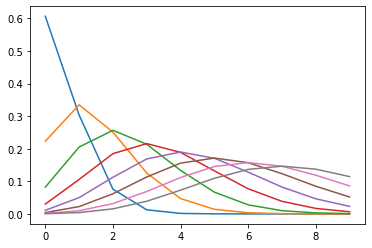

In [134]:
# distribution (to see mode)
for k1 in [x + 0.5 for x in range(8)]:
    k2 = 1
    dist = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(10)]
    plt.plot(dist)
plt.show()

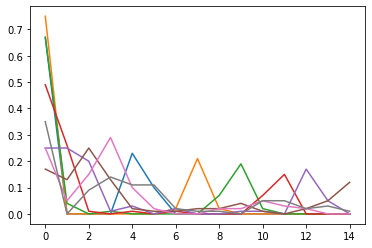

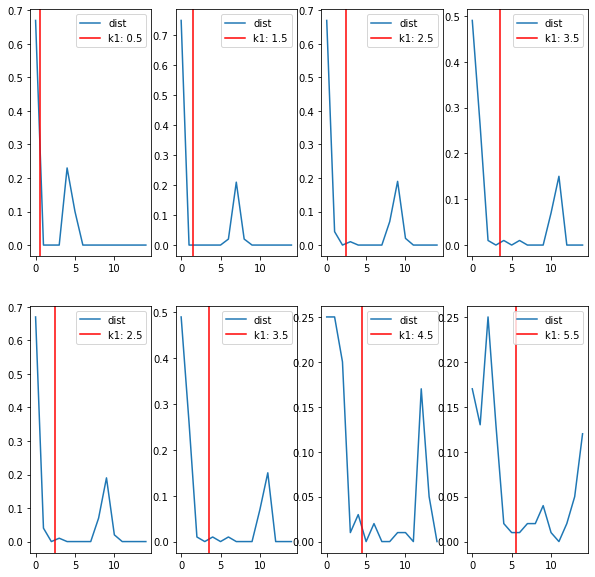

In [135]:
distributions_unimodal = []
k1_list = [x + 0.5 for x in range(8)]
for k1 in k1_list:
    dist = equation_distribution([k1,1],100,15)
    distributions_unimodal.append(dist)

nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        idx = i * nrows + j
        k1 = k1_list[idx]
        ax[i,j].plot(distributions_unimodal[idx])
        ax[i,j].axvline(k1, color='red')
        ax[i,j].legend(['dist',f'k1: {k1}'])
plt.show()

Now see that small peaks appear around the modal states, and they do sometimes give the best solution interval when the bi-modal issue does not arise. However, we see that the much larger peak at states far away from the mode states still remains.

# Multiple equations

In practice will use multiple equations, usually as many as possible, so want to see how many is enough.

- simulate bounds
- solve LP using 1st equation, 1st and 2nd eqns, ...
- plot plot width of solution interval against total # used (as well as visual intervals for clarity)
- repeat for several bounds to see trend

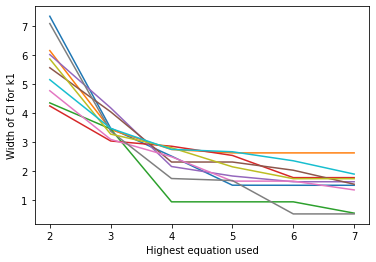

In [81]:
k1 = 5
for k in range(10):
    # compute CI bounds on p(x)'s
    estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]
    # store results
    solution_width = []
    equation = []
    # solve LP using equations [0,1,...,n-1] for increasing n values
    for n in range(2,8):
        lb, ub = birth_death_LP([x for x in range(n)],pl,pu)
        try:
            solution_width.append(ub - lb)
            equation.append(n)
        except TypeError:
            print(f"Type error for equation {n}")
    plt.plot(equation,solution_width)
plt.xlabel("Highest equation used")
plt.ylabel("Width of CI for k1")
plt.show()

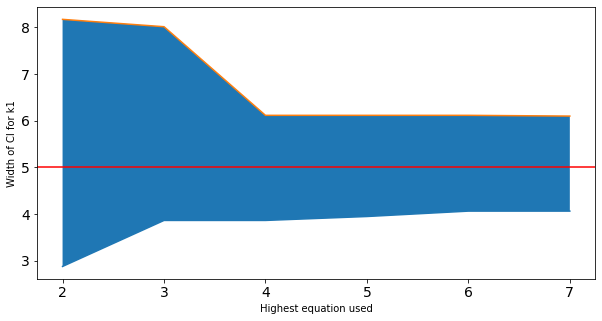

In [82]:
k1 = 5
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# store results
ubs = []
lbs = []
equation = []
# solve LP using equations [0,1,...,n-1] for increasing n values
for n in range(2,8):
    try:
        lb, ub = birth_death_LP([x for x in range(n)],pl,pu)
    except:
        lb = 0
        ub = 30
    if ub > 30:
        ub = 30
    ubs.append(ub)
    lbs.append(lb)
    equation.append(n)
fig, ax = plt.subplots(figsize=(10,5))
plt.tick_params(labelsize=14)
plt.xlabel("Highest equation used")
plt.ylabel("Width of CI for k1")
ax.plot(equation,lbs)
ax.plot(equation,ubs)
ax.fill_between(equation,lbs,ubs)
ax.axhline(k1, color="red")

Also try starting with e.g. 10th equation, then 9th and 10th equations, ... adding in reverse:

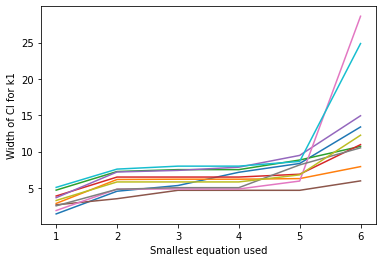

In [83]:
k1 = 5
for k in range(10):
    # compute CI bounds on p(x)'s
    estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]
    # store results
    solution_width = []
    equation = []
    # solve LP using equations [0,1,...,n-1] for increasing n values
    for n in range(2,8):
        lb, ub = birth_death_LP([8 - x for x in range(n)],pl,pu)
        try:
            solution_width.append(ub - lb)
            equation.append(7 - (n-1))
        except TypeError:
            print(f"Type error for equation {n}")
    plt.plot(equation,solution_width)
plt.xlabel("Smallest equation used")
plt.ylabel("Width of CI for k1")
plt.show()

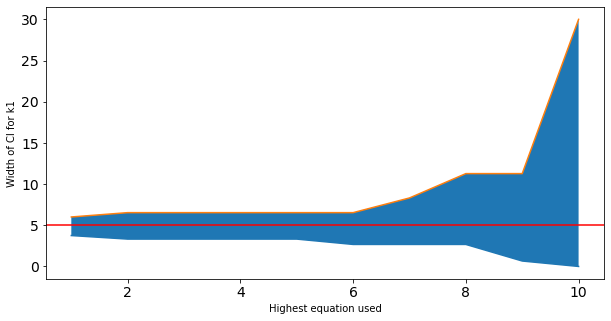

In [84]:
k1 = 5
max_eqn = 10
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# store results
ubs = []
lbs = []
equation = []
# solve LP using equations [0,1,...,n-1] for increasing n values
for n in range(max_eqn,0,-1):
    try:
        lb, ub = birth_death_LP([x for x in range(n,max_eqn + 1)],pl,pu)
    except:
        lb = 0
        ub = 30
    if ub > 30:
        ub = 30
    ubs.append(ub)
    lbs.append(lb)
    equation.append(n)
fig, ax = plt.subplots(figsize=(10,5))
plt.tick_params(labelsize=14)
plt.xlabel("Highest equation used")
plt.ylabel("Width of CI for k1")
ax.plot(equation,lbs)
ax.plot(equation,ubs)
ax.fill_between(equation,lbs,ubs)
ax.axhline(k1, color="red")